# Pooling-imputation performance from real bead chip data

Performs pooling simulation and imputation on data from the chromosome 20 of 1000GP.
Markers have been chosen as the intersection between the real bead chip Illumina Infinium OmniExpress
 (https://support.illumina.com/array/array_kits/humanomniexpress-24-beadchip-kit/downloads.html) 
 and the chr20 1000GP data. The samples are randomly assigned to the reference panel or the study population.

Extract markers coordinates of this bead chip, provided on the manufacturer website 
(https://support.illumina.com/content/dam/illumina-support/documents/downloads/productfiles/humanomniexpress-24/v1-3/infinium-omniexpress-24-v1-3-a1-physical-genetic-coordinates.zip)

Subset markers from the 1000GP project based on this markers list

Apply pooling simulation on this data, and imputation (run parallel execution): 
**impute for whole K20 and plot result for bead chip only**

In [1]:
import os

os.mkdir('/home/camille/PoolImpHuman/data/20200708')

In [2]:
os.chdir('/home/camille/PoolImpHuman/data/20200708')

In [3]:
print('Configure directory')
%sx ln -s ~/1000Genomes/scripts/VCFPooling/python/omniexpress_20200708.ipynb ./
%sx ln -s /home/camille/PoolImpHuman/data/omniexpress/InfiniumOmniExpress-chr20-CHROM-POS.txt ./
%sx ln -s /home/camille/PoolImpHuman/data/20200706/IMP.samples ./

Configure directory


[]

### Prepare VCF files

In [4]:
print('Create files to compare: select bead chip markers from the chromosome 20, both original file and pooled + imputed')
%sx bcftools view -Oz -o IMP.chr20.snps.gt.vcf.gz -R InfiniumOmniExpress-chr20-CHROM-POS.txt ../20200706/IMP.chr20.snps.gt.vcf.gz
%sx bcftools view -Oz -o IMP.chr20.pooled.imputed.vcf.gz -R InfiniumOmniExpress-chr20-CHROM-POS.txt ../20200706/IMP.chr20.pooled.imputed.vcf.gz

Create files to compare: select bead chip markers from the chromosome 20, both original file and pooled + imputed


['[W::hts_idx_load2] The index file is older than the data file: ../20200706/IMP.chr20.pooled.imputed.vcf.gz.csi',
 '[W::hts_idx_load2] The index file is older than the data file: ../20200706/IMP.chr20.pooled.imputed.vcf.gz.csi']

In [5]:
print('Index files created')
%sx bcftools index -f IMP.chr20.snps.gt.vcf.gz
%sx bcftools index -f IMP.chr20.pooled.imputed.gt.vcf.gz
%sx bcftools index -f IMP.chr20.pooled.beagle2.gl.corr.vcf.gz

Index files created


['[E::hts_open_format] Failed to open file IMP.chr20.pooled.beagle2.gl.corr.vcf.gz',
 'index: failed to open "IMP.chr20.pooled.beagle2.gl.corr.vcf.gz"']

In [6]:
print('Check number of samples')
%sx bcftools query -l IMP.chr20.snps.gt.vcf.gz | wc -l
%sx bcftools query -l IMP.chr20.pooled.imputed.gt.vcf.gz | wc -l

Check number of samples


['[E::hts_open_format] Failed to open file IMP.chr20.pooled.imputed.gt.vcf.gz',
 'Failed to open IMP.chr20.pooled.imputed.gt.vcf.gz: No such file or directory',
 '0']

In [7]:
print('Check number of intersected markers')
%sx bcftools view -H IMP.chr20.snps.gt.vcf.gz | wc -l
%sx bcftools view -H IMP.chr20.pooled.imputed.gt.vcf.gz | wc -l

Check number of intersected markers


['[E::hts_open_format] Failed to open file IMP.chr20.pooled.imputed.gt.vcf.gz',
 'Failed to open IMP.chr20.pooled.imputed.gt.vcf.gz: No such file or directory',
 '0']

### Compute results with bcftools stats

In [8]:
print('Plotting results with bcftools stats')

Plotting results with bcftools stats


See bcfstats_quality

### Compute results with customized metrics

In [9]:
paths = {'beaglegt': {
    'true': '/home/camille/PoolImpHuman/data/20200708/IMP.chr20.snps.gt.vcf.gz',
    'imputed': '/home/camille/PoolImpHuman/data/20200708/IMP.chr20.pooled.imputed.vcf.gz'},
         'beaglegl': {
     'true': '/home/camille/PoolImpHuman/data/20200708/IMP.chr20.snps.gl.vcf.gz',
     'imputed': '/home/camille/PoolImpHuman/data/20200708/IMP.chr20.pooled.imputed.vcf.gz'},
}

In [10]:
import subprocess

convertgtgl = True
if convertgtgl:
    cmd = 'bash ~/PoolImpHuman/bin/bash-scripts/gt_to_gl.sh {} {}'.format(paths['beaglegt']['true'], paths['beaglegl']['true'])
    subprocess.run(cmd, shell=True,)

In [12]:
import pandas as pd
from scripts.VCFPooling.poolSNPs.metrics import quality

In [13]:
qbeaglegt = quality.QualityGT(*paths['beaglegt'].values(), 0, idx='id')

In [14]:
qbeaglegl = quality.QualityGL(paths['beaglegl']['true'], paths['beaglegl']['imputed'], 0, idx='id')
messbeagle = qbeaglegl.cross_entropy

In [15]:
#qbeaglegl = quality.QualityGT(*paths['beaglegt'].values(), 0, idx='id')
tabbeaglegl = pd.concat([qbeaglegt.concordance(),
                       qbeaglegt.trueobj.af_info,
                       qbeaglegt.pearsoncorrelation(),
                       qbeaglegt.precision,
                       qbeaglegt.accuracy,
                       qbeaglegt.recall,
                       qbeaglegt.f1_score,
                        qbeaglegl.cross_entropy], axis=1)
dosbeaglegl = qbeaglegt.alleledosage()


In [16]:
tabbeaglegl.head()

,concordance,af_info,r_squared,precision_score,accuracy_score,recall_score,f1_score,cross_entropy
variants,,,,,,,,
rs6139074,0.625000,0.218251,NaN,0.455625,0.675000,0.675000,0.544030,1.625000
rs1418258,0.408333,0.439497,0.090304,0.540767,0.479167,0.479167,0.441145,2.604167
rs6086616,0.320833,0.571286,0.010635,0.298101,0.383333,0.383333,0.335034,3.083333
rs6039403,0.316667,0.379393,0.005392,0.347941,0.416667,0.416667,0.367270,2.916667
rs6040395,0.908333,0.070088,0.364827,0.894447,0.912500,0.912500,0.890419,0.437500


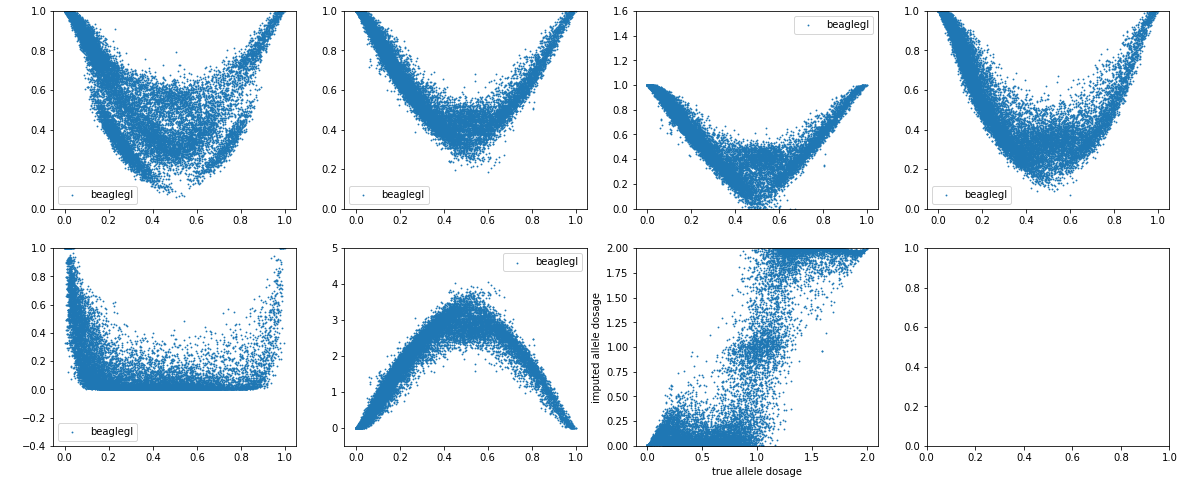

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5*4, 4*2]
fig, axes = plt.subplots(2, 4)

tabbeaglegl.plot.scatter('af_info', 'precision_score', ax=axes[0, 0], s=0.7, label='beaglegl')
axes[0, 0].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'accuracy_score', ax=axes[0, 1], s=0.7, label='beaglegl')
axes[0, 1].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'concordance', ax=axes[0, 2], s=0.7, label='beaglegl')
axes[0, 2].set_ylim(0.0, 1.6)
tabbeaglegl.plot.scatter('af_info', 'f1_score', ax=axes[0, 3], s=0.7, label='beaglegl')
axes[0, 3].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'r_squared', ax=axes[1, 0], s=0.7, label='beaglegl')
axes[1, 0].set_ylim(-0.4, 1.0)
tabbeaglegl.plot.scatter('af_info', 'cross_entropy', ax=axes[1, 1], s=0.7, label='beaglegl')
axes[1, 1].set_ylim(-0.5, 5.0)
axes[1, 2].scatter(dosbeaglegl[0], dosbeaglegl[1], s=0.7, label='beaglegl')
axes[1, 2].set_xlabel('true allele dosage')
axes[1, 2].set_ylabel('imputed allele dosage')
axes[1, 2].set_ylim(0.0, 2.0)

for ax in axes.flatten()[:-2]:
    # cast color to white 'w' if dark background
    ax.set_xlabel('true alternate allele frequency', color='w')
    ax.set_ylabel(ax.get_ylabel(), color='w')
plt.savefig(os.path.join(os.path.dirname(paths['beaglegt']['imputed']), 'imputation_quality_gtgl.png'))
plt.show()
